<a href="https://colab.research.google.com/github/zergswim/Diffusion/blob/main/DiffusionTest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [56]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"

mnist_train = torchvision.datasets.MNIST(root='./data', train=True, download=True,
                                          transform=torchvision.transforms.ToTensor())
mnist_train, mnist_val = random_split(mnist_train, [500, 59500])

train_loader = DataLoader(mnist_train, batch_size=32, shuffle=True)
val_loader = DataLoader(mnist_val, batch_size=32)

class Diffusion(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Linear(784, 256),
            nn.ReLU(),
            nn.Linear(256, 128)
        ).to(device)

        self.decoder = nn.Sequential(
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 784),
            nn.Sigmoid()
        ).to(device)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # 입력 x를 평탄화합니다.
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat

def train(model, noise_fn, loop):
  optimizer = torch.optim.Adam(model.parameters())

  from skimage.util import random_noise

  # 모델 사전 학습
  for epoch in range(loop):
      for batch in train_loader:
          images, _ = batch
          images = images.to(device)
          images_flat = images.view(images.size(0), -1)

          for r in range(10):
            #노이즈 추가
            noisy_img = noise_fn(images_flat)

            reconstructed = model(noisy_img)
            loss = F.mse_loss(reconstructed, images_flat)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # print(f"repeat: {r}, Loss: {loss.item()}")
            images_flat = reconstructed.detach()

      print(f"Epoch {epoch}, Loss: {loss.item()}")

Epoch 0, Loss: 5.8042256569024175e-05
Epoch 1, Loss: 0.00029764670762233436
Epoch 2, Loss: 0.00045063794823363423
Epoch 3, Loss: 0.00041449881973676383
Epoch 4, Loss: 0.0009117705631069839
Epoch 5, Loss: 0.0010034721344709396
Epoch 6, Loss: 0.0007923214579932392
Epoch 7, Loss: 0.0009056150447577238
Epoch 8, Loss: 0.0010466105304658413
Epoch 9, Loss: 0.0008624029578641057


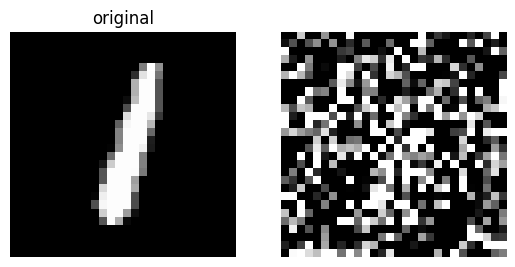

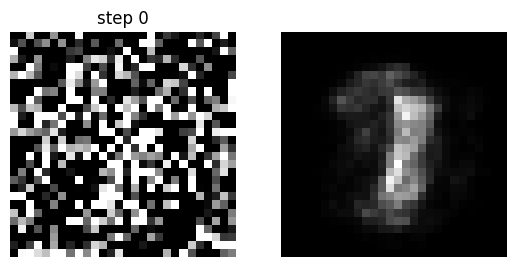

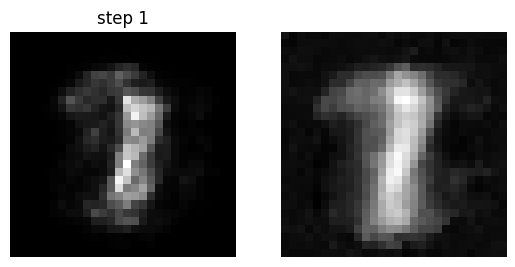

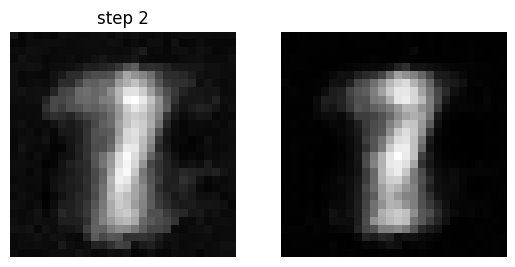

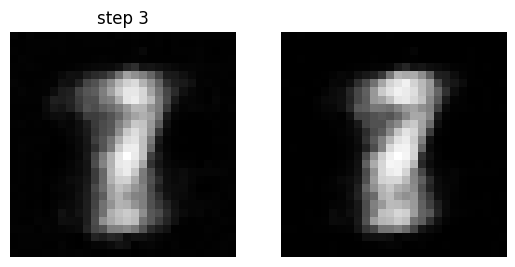

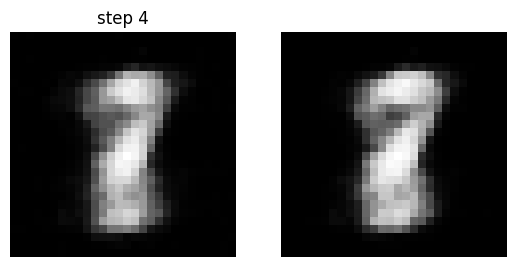

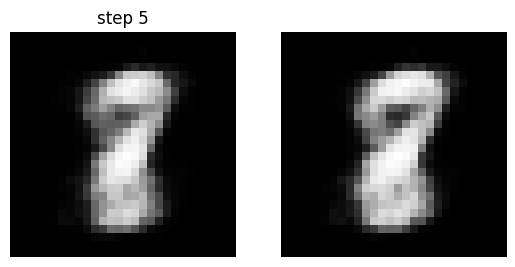

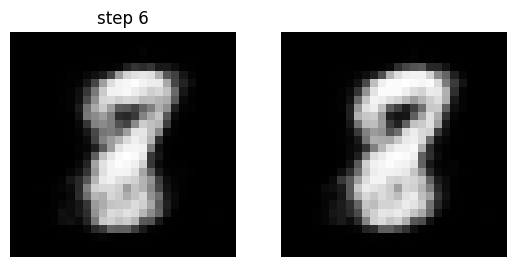

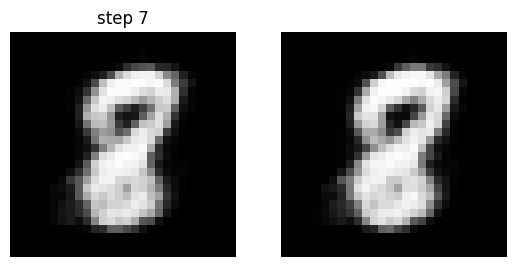

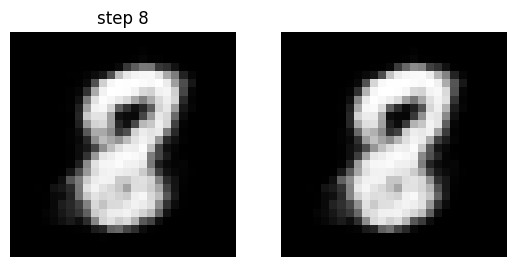

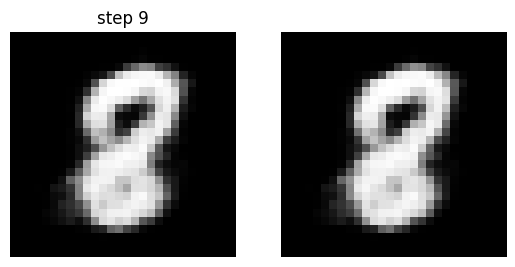

In [88]:
from skimage.util import random_noise

def show(img, img_r, title):
  plt.subplot(1, 2, 1)
  plt.imshow(img, cmap="gray")
  plt.axis('off')
  plt.title(title)
  plt.subplot(1, 2, 2)
  plt.imshow(img_r, cmap="gray")
  plt.axis('off')
  plt.show()

def noise_fn(img_flat, var=0.1):
  return torch.Tensor(random_noise(img_flat, var=var))

model = Diffusion().to(device)
train(model, noise_fn, 10) #랜덤 노이즈로 학습

# 잡음 추가 및 재구성
origin, _ = next(iter(val_loader))
origin = origin.to(device)

with torch.no_grad():
    origin_flat = origin.view(origin.size(0), -1)
    origin_reconstructed = model(origin_flat)

    img_flat = origin_flat
    noisy_img = noise_fn(img_flat, var=1.0) #랜덤 노이즈 이미지

    img = img_flat[0].cpu().reshape(28, 28)
    img_r = noisy_img[0].cpu().reshape(28, 28)
    show(img, img_r, 'original')

    for r in range(10):
      noisy_reconstructed = model(noisy_img)

      img = noisy_img[0].cpu().reshape(28, 28)
      img_r = noisy_reconstructed[0].cpu().reshape(28, 28)
      show(img, img_r, f'step {r}')

      noisy_img = noisy_reconstructed

Epoch 0, Loss: 1.638583853491582e-05
Epoch 1, Loss: 5.545582826016471e-05
Epoch 2, Loss: 5.1226787036284804e-05
Epoch 3, Loss: 6.891712837386876e-05
Epoch 4, Loss: 0.00010992852912750095
Epoch 5, Loss: 0.00019205418357159942
Epoch 6, Loss: 0.00019668439927045256
Epoch 7, Loss: 0.0002305976377101615
Epoch 8, Loss: 0.00016324648458976299
Epoch 9, Loss: 0.0001621103147044778


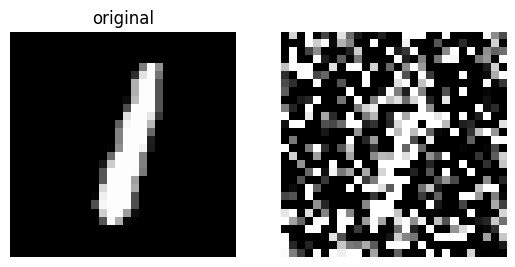

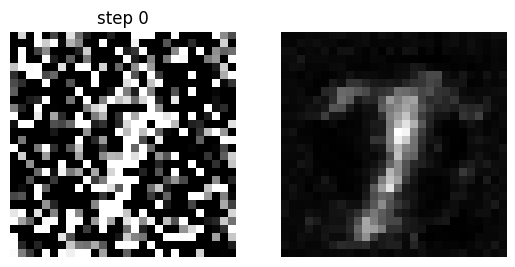

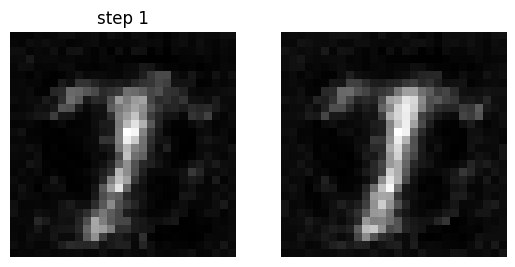

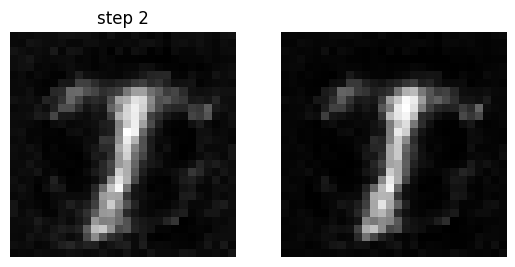

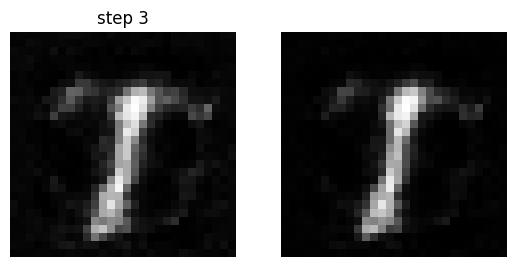

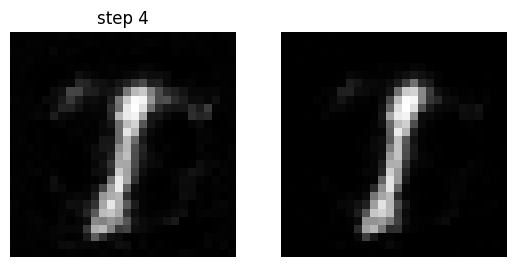

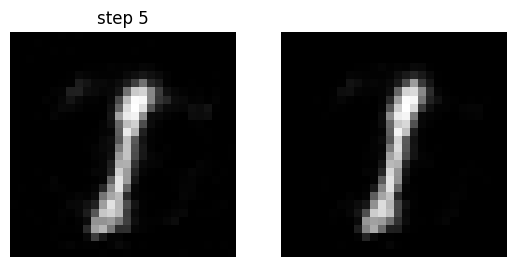

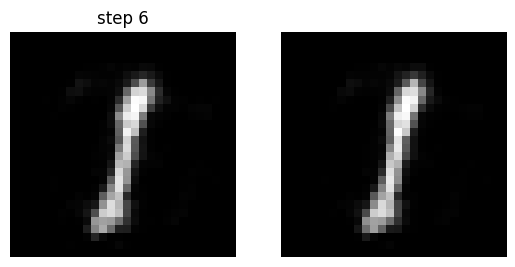

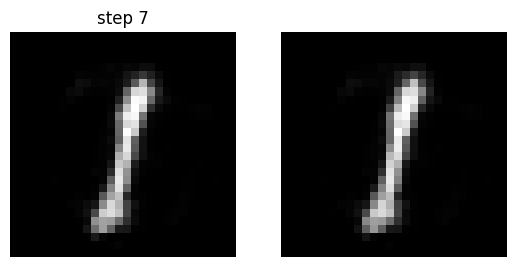

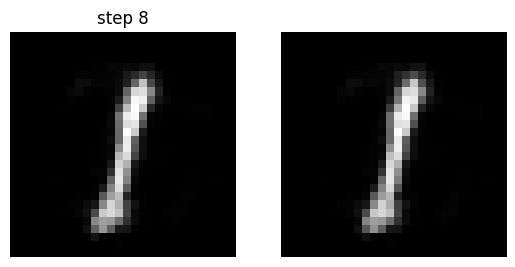

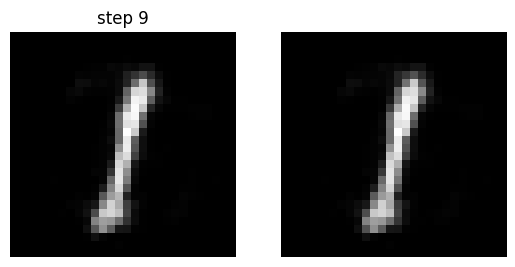

In [89]:
import numpy as np

def langevin_dynamics(x_0, n_steps=10, step_size=0.01):

    # 스코어 함수
    def score_fn(x):
        noisy_data = x + np.random.normal(0, 1, size=x.size())
        return x - noisy_data

    x = x_0
    for i in range(n_steps):
        grad = score_fn(x)
        noise = np.random.normal(0, step_size, size=x.shape)
        x = x + step_size*grad + noise
    return torch.Tensor(x).float()


model = Diffusion().to(device)
train(model, langevin_dynamics, 10) #langevin_dynamics 로 훈련

# 잡음 추가 및 재구성
origin, _ = next(iter(val_loader))
origin = origin.to(device)

with torch.no_grad():
    origin_flat = origin.view(origin.size(0), -1)
    origin_reconstructed = model(origin_flat)

    img_flat = origin_flat
    noisy_img = noise_fn(img_flat, var=1.0) #랜덤 노이즈 이미지

    img = img_flat[0].cpu().reshape(28, 28)
    img_r = noisy_img[0].cpu().reshape(28, 28)
    show(img, img_r, 'original')

    for r in range(10):
      noisy_reconstructed = model(noisy_img)

      img = noisy_img[0].cpu().reshape(28, 28)
      img_r = noisy_reconstructed[0].cpu().reshape(28, 28)
      show(img, img_r, f'step {r}')

      noisy_img = noisy_reconstructed